<a href="https://colab.research.google.com/github/hlx73/Image_ditiction_project/blob/main/assignment2_ML_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip3 install -U ucimlrepo

from sklearn.datasets import load_breast_cancer, fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage


In [ ]:
# Load dataset from sklearn
bc = load_breast_cancer()

X_bc = pd.DataFrame(bc.data, columns=bc.feature_names)
y_bc = pd.Series(bc.target)

# Scale features
scaler_bc = StandardScaler()
X_bc_scaled = scaler_bc.fit_transform(X_bc)


In [ ]:
from ucimlrepo import fetch_ucirepo

# Load Adult dataset from UCI ML Repository
adult_data = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X_ad = adult_data.data.features
y_ad = adult_data.data.targets

# Adjust the target variable 'y_ad' to be binary (0 or 1)
# Assuming 'income' is the target column name from adult_data.variables
y_ad = (y_ad['income'] == '>50K').astype(int)

# Identify numeric and categorical columns
num_cols = X_ad.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_ad.select_dtypes(include=["object"]).columns

# Preprocessing pipeline
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# Fit + transform
X_ad_processed = preprocessor.fit_transform(X_ad)

In [ ]:
# Breast Cancer split
Xbc_train, Xbc_test, ybc_train, ybc_test = train_test_split(
    X_bc_scaled, y_bc, test_size=0.3, random_state=42, stratify=y_bc
)

# Adult split
Xad_train, Xad_test, yad_train, yad_test = train_test_split(
    X_ad_processed, y_ad, test_size=0.3, random_state=42, stratify=y_ad
)


In [ ]:
def run_svm_linear_fast(X_train, y_train):
    model = SVC(kernel="linear", C=1, probability=True)
    model.fit(X_train, y_train)
    return model

def run_svm_rbf_fast(X_train, y_train):
    model = SVC(kernel="rbf", C=1, gamma="scale", probability=True)
    model.fit(X_train, y_train)
    return model


In [ ]:
svm_bc_lin = run_svm_linear_fast(Xbc_train, ybc_train)
svm_bc_rbf = run_svm_rbf_fast(Xbc_train, ybc_train)


In [ ]:
svm_ad_lin = run_svm_linear_fast(Xad_train, yad_train)
svm_ad_rbf = run_svm_rbf_fast(Xad_train, yad_train)


In [ ]:
def evaluate(model, X_test, y_test, title):
    # The models are directly SVC objects, not GridSearchCV objects, so no best_estimator_ needed
    # best = model.best_estimator_ # This line caused the error

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print("=== ", title, " ===")
    # print("Best Params:", model.best_params_) # This line also caused an error for direct SVC models
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_prob))

    # Confusion Matrix
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title(title + " - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)
    plt.title(title + " - ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

===  Breast SVM Linear  ===
Accuracy: 0.9824561403508771
Precision: 0.9814814814814815
Recall: 0.9906542056074766
F1: 0.986046511627907
AUC: 0.9940128504672897


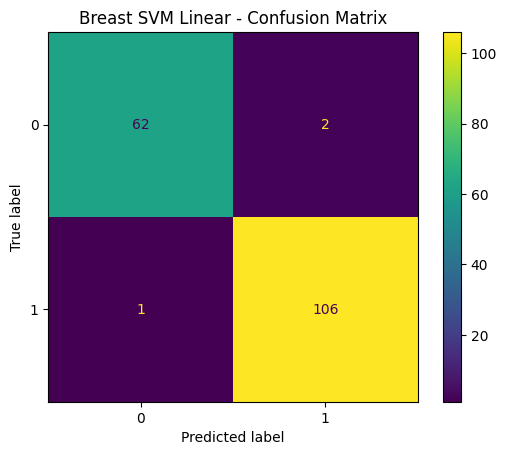

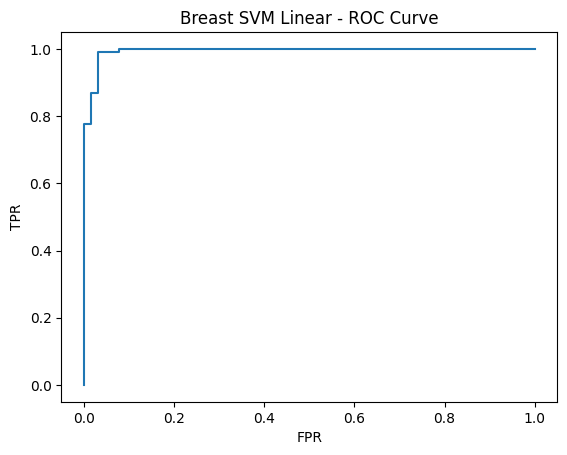

===  Breast SVM RBF  ===
Accuracy: 0.9766081871345029
Precision: 0.9813084112149533
Recall: 0.9813084112149533
F1: 0.9813084112149533
AUC: 0.997517523364486


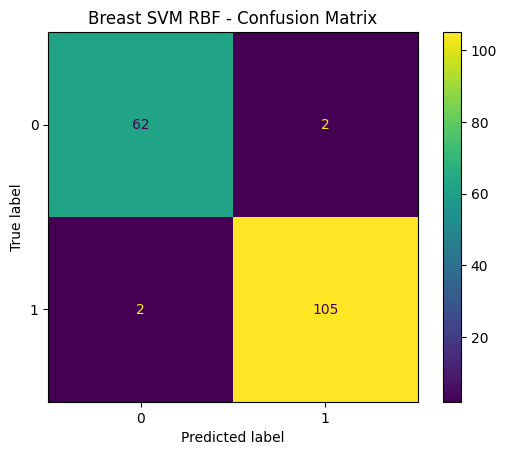

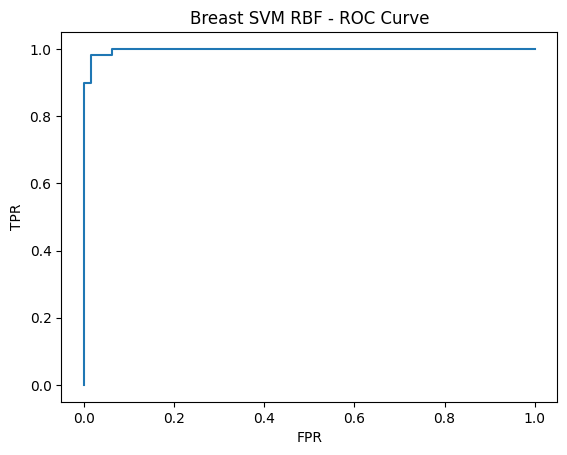

===  Adult SVM Linear  ===
Accuracy: 0.8419436292909301
Precision: 0.581081081081081
Recall: 0.0548469387755102
F1: 0.10023310023310024
AUC: 0.8536833601825413


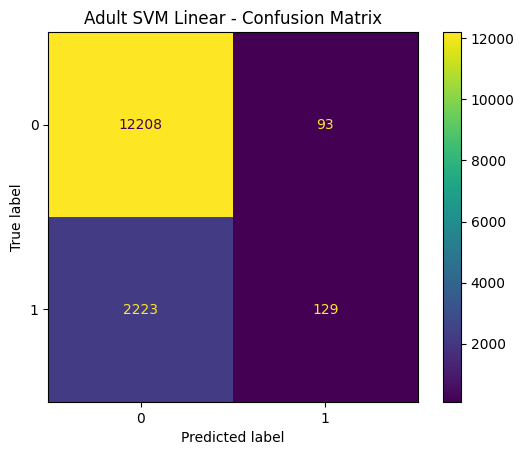

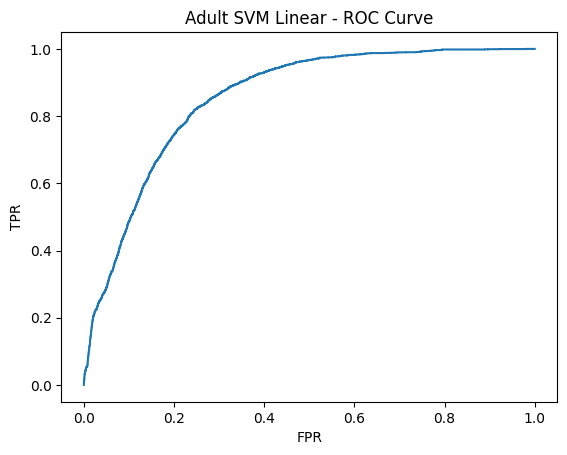

===  Adult SVM RBF  ===
Accuracy: 0.8545007848222207
Precision: 0.63189448441247
Recall: 0.22406462585034015
F1: 0.3308223477715003
AUC: 0.8366084148072692


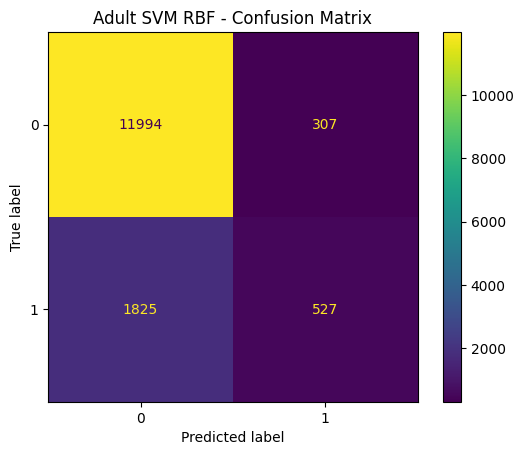

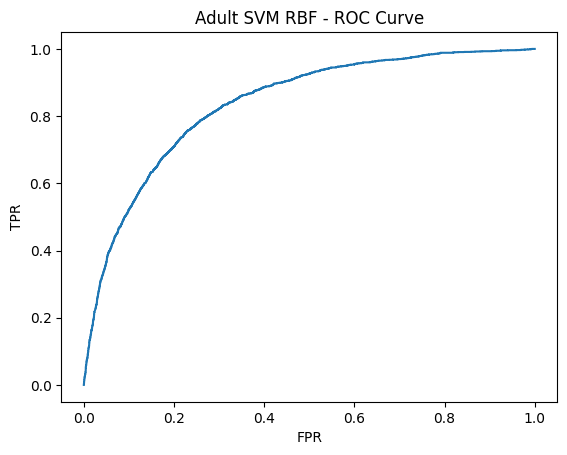

In [ ]:
evaluate(svm_bc_lin, Xbc_test, ybc_test, "Breast SVM Linear")
evaluate(svm_bc_rbf, Xbc_test, ybc_test, "Breast SVM RBF")

evaluate(svm_ad_lin, Xad_test, yad_test, "Adult SVM Linear")
evaluate(svm_ad_rbf, Xad_test, yad_test, "Adult SVM RBF")

In [ ]:
def run_kmeans(X, name):
    km = KMeans(n_clusters=2, random_state=42)
    labels = km.fit_predict(X)

    sil = silhouette_score(X, labels)
    print(name, "Silhouette Score:", sil)

    return labels


In [ ]:
km_bc = run_kmeans(X_bc_scaled, "Breast")
km_ad = run_kmeans(X_ad_processed, "Adult")


Breast Silhouette Score: 0.3447344346611054
Adult Silhouette Score: 0.34533193813994806


In [ ]:
def run_hierarchical(X, name):
    # --- Reduce data size to avoid RAM crash ---
    import numpy as np

    max_samples = 500
    if X.shape[0] > max_samples:
        idx = np.random.choice(X.shape[0], max_samples, replace=False)
        X_small = X[idx]
    else:
        # If no subsampling, use all indices
        idx = np.arange(X.shape[0])
        X_small = X

    # Linkage for dendrogram
    Z = linkage(X_small, method="average")

    plt.figure(figsize=(10, 5))
    dendrogram(Z, truncate_mode="level", p=5)
    plt.title(name + " Dendrogram")
    plt.show()

    # Clustering labels (also use reduced data)
    ag = AgglomerativeClustering(n_clusters=2, linkage="average")
    labels = ag.fit_predict(X_small)

    return labels, idx

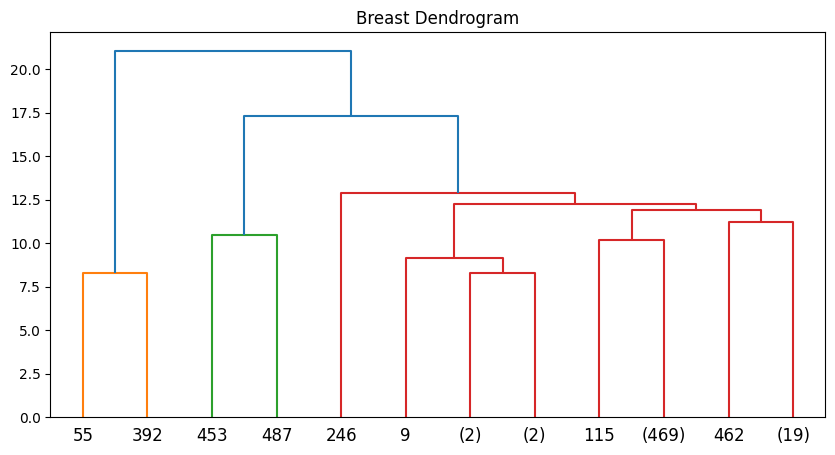

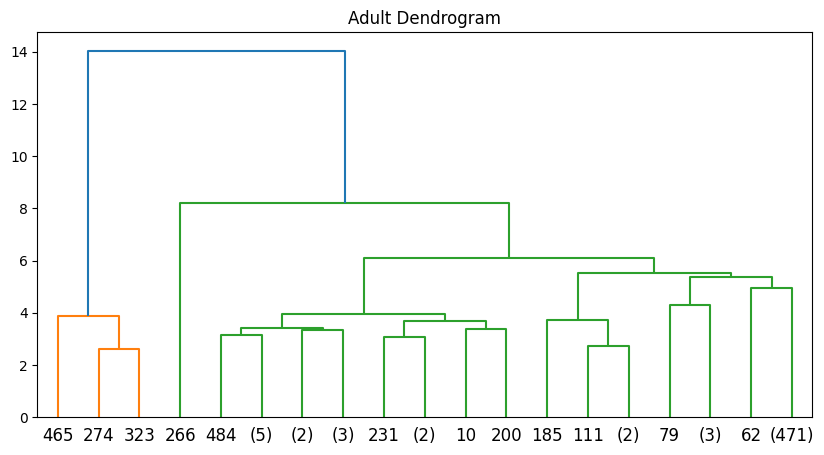

In [ ]:
hier_bc, hier_bc_idx = run_hierarchical(X_bc_scaled, "Breast")
hier_ad, hier_ad_idx = run_hierarchical(X_ad_processed.toarray(), "Adult")

In [ ]:
import seaborn as sns

def compare_clusters(labels, true, title):
    print("=== ", title, " ===")
    tab = pd.crosstab(labels, true)
    print(tab)

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(tab, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title + " - Cross-Tabulation")
    plt.xlabel("True Labels")
    plt.ylabel("Cluster Labels")
    plt.show()

    return tab

===  Breast KMeans vs True  ===
col_0    0    1
row_0          
0      175   13
1       37  344


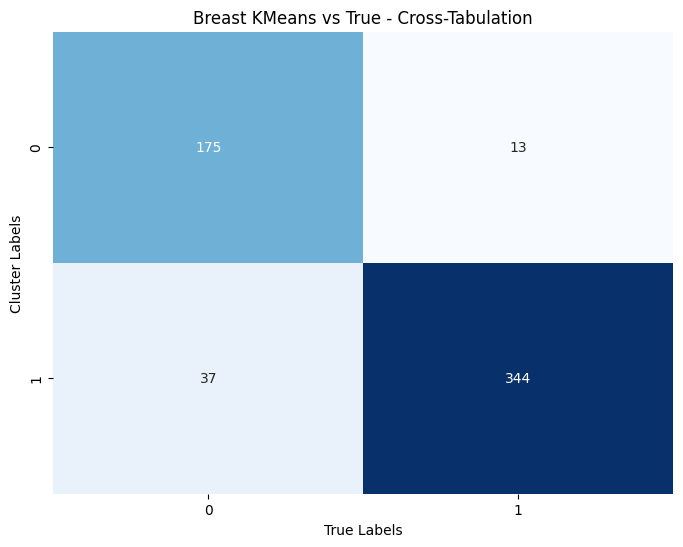

===  Breast Hierarchical vs True  ===
col_0    0    1
row_0          
0      180  318
1        2    0


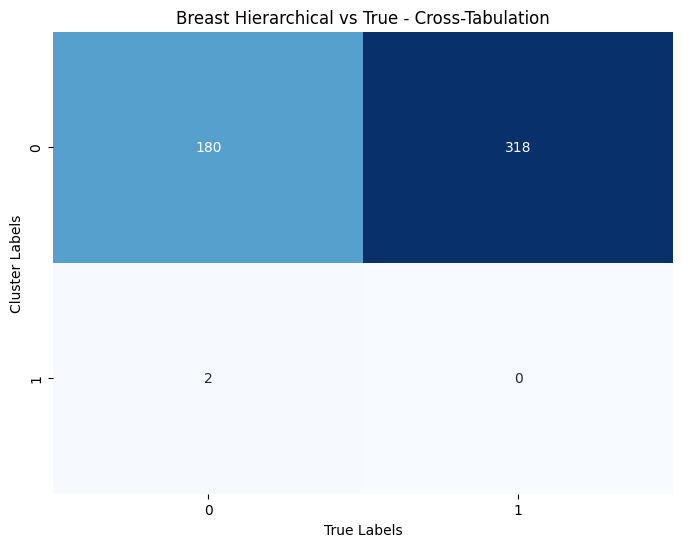

===  Adult KMeans vs True  ===
income      0     1
row_0              
0       39535  7070
1        1466   771


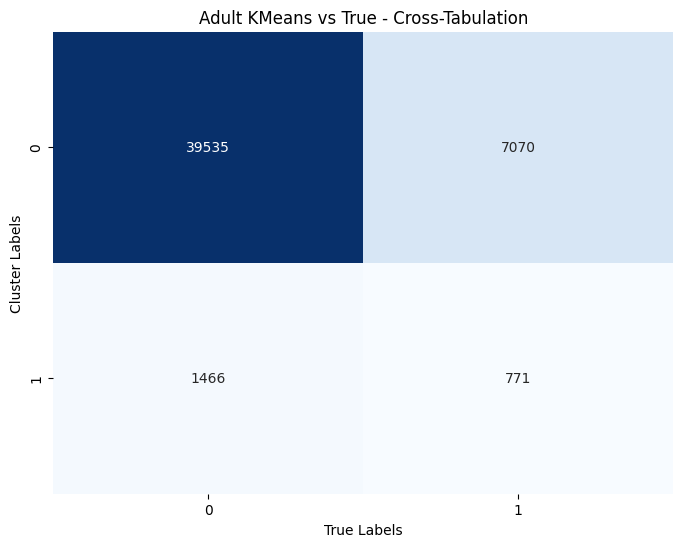

===  Adult Hierarchical vs True  ===
income    0   1
row_0          
0       406  91
1         0   3


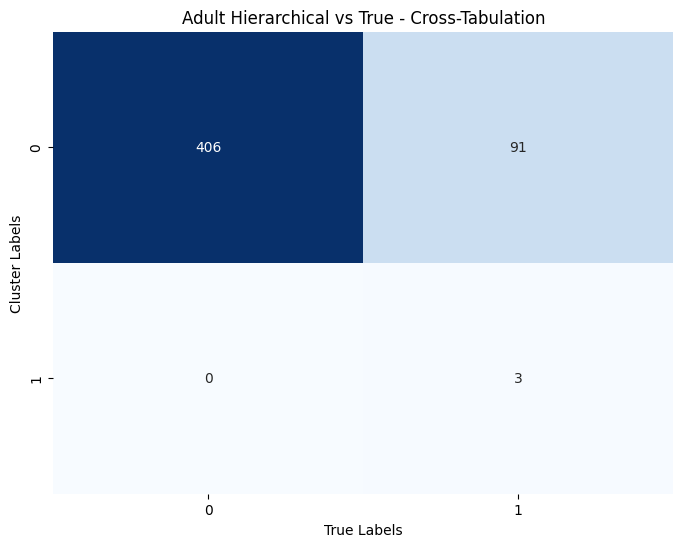

income,0,1
row_0,,
0,406,91
1,0,3


In [ ]:
compare_clusters(km_bc, y_bc, "Breast KMeans vs True")
# Use the indices returned by run_hierarchical to align y_bc with hier_bc
compare_clusters(hier_bc, y_bc.iloc[hier_bc_idx], "Breast Hierarchical vs True")

compare_clusters(km_ad.toarray() if hasattr(km_ad, "toarray") else km_ad,
                 y_ad,
                 "Adult KMeans vs True")

# Use the indices returned by run_hierarchical to align y_ad with hier_ad
compare_clusters(hier_ad, y_ad.iloc[hier_ad_idx], "Adult Hierarchical vs True")

In [ ]:
def pca_plot(X, labels, title):
    pca = PCA(n_components=2)
    X2 = pca.fit_transform(X)

    plt.scatter(X2[:,0], X2[:,1], c=labels, s=10)
    plt.title(title)
    plt.show()


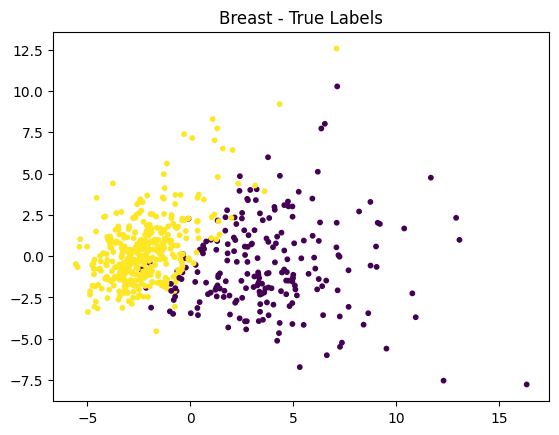

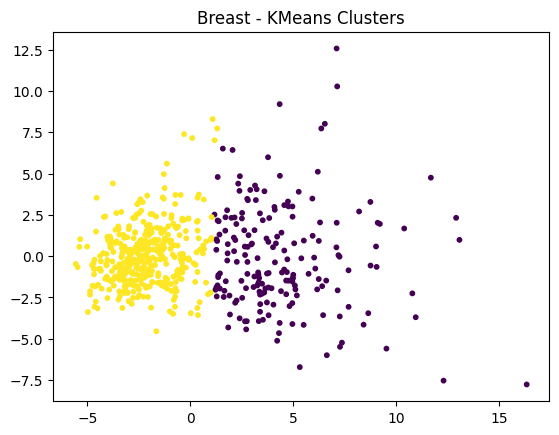

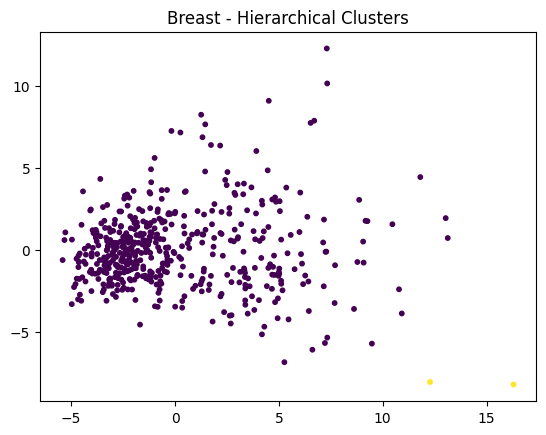

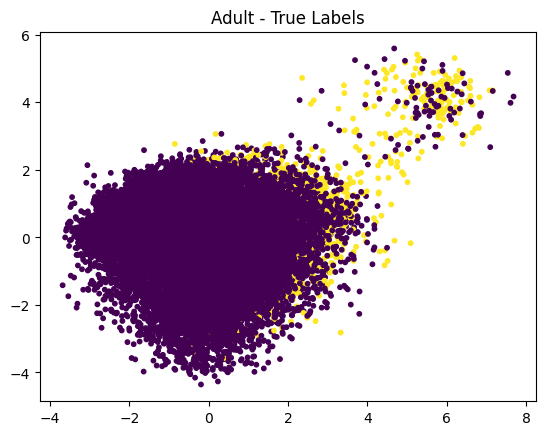

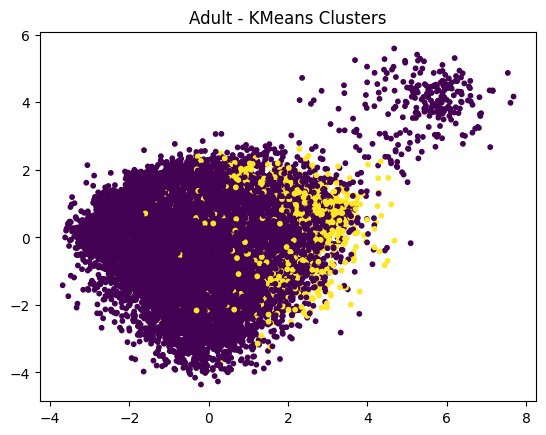

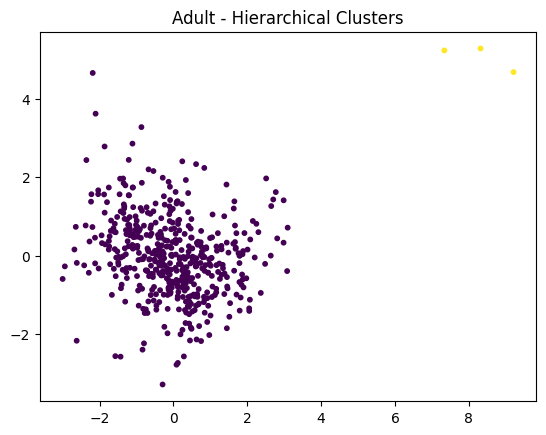

In [ ]:
# Breast
pca_plot(X_bc_scaled, y_bc, "Breast - True Labels")
pca_plot(X_bc_scaled, km_bc, "Breast - KMeans Clusters")
pca_plot(X_bc_scaled[hier_bc_idx], hier_bc, "Breast - Hierarchical Clusters")

# Adult
pca_plot(X_ad_processed, y_ad, "Adult - True Labels")
pca_plot(X_ad_processed, km_ad, "Adult - KMeans Clusters")
pca_plot(X_ad_processed[hier_ad_idx].toarray(), hier_ad, "Adult - Hierarchical Clusters")

In [ ]:
print("""
SVM models clearly outperform clustering for both datasets.
- Breast Cancer: RBF SVM performs best.
- Adult Dataset: Linear SVM performs best due to high dimensionality.
- Clustering works moderately on Breast Cancer but poorly on Adult.
""")



SVM models clearly outperform clustering for both datasets.
- Breast Cancer: RBF SVM performs best.
- Adult Dataset: Linear SVM performs best due to high dimensionality.
- Clustering works moderately on Breast Cancer but poorly on Adult.

